# Mean-Variance frontier with made-up data

Let us first import packages that we need for our analysis

In [114]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

Here we manually input the expected returns, variances and correlations of Cash (C), Bonds (B), Stocks (S), and Private Equity (E)

In [118]:
# Data

# Expected returns
mu_C = 0.02   # Cash
mu_B = 0.054  # Bonds
mu_S = 0.066  # Stocks (public equity)
mu_E = 0.098  # Private equity

# Volatilities
sigma_C = 0.0
sigma_B = 0.075
sigma_S = 0.133
sigma_E = 0.164

# Correlations
rho_CC = 1.0
rho_CB = 0.0
rho_CS = 0.0
rho_CE = 0.0

rho_BC = rho_CB
rho_BB = 1.0
rho_BS = 0.08
rho_BE = 0.06

rho_SC = rho_CS
rho_SB = rho_BS
rho_SS = 1.0
rho_SE = 0.14

rho_EC = rho_CE
rho_EB = rho_BE
rho_ES = rho_SE
rho_EE = 1


# Collect data of risky assets in vector/matrix form

mu_vec = np.array([mu_B, mu_S, mu_E])
sigmas   = np.array([sigma_B, sigma_S, sigma_E])

asset_labels = ['B', 'S', 'E']

#correlation matrix -- Risky assets only
corr = np.array([
    [rho_BB, rho_BS, rho_BE],
    [rho_SB, rho_SS, rho_SE],
    [rho_EB, rho_ES, rho_EE]
])

#correlation matrix -- Risky and riskless assets
# corr = np.array([
#     [rho_CC, rho_CB, rho_CS, rho_CE],
#     [rho_BC, rho_BB, rho_BS, rho_BE],
#     [rho_SC, rho_SB, rho_SS, rho_SE],
#     [rho_EC, rho_EB, rho_ES, rho_EE]
# ])

# Variance-covariance matrix = sigma*sigma^T .* rho

cov_matrix = np.outer(sigmas, sigmas) * corr #covariance matrix
risk_free_rate = mu_C  # Risk-free rate is the expected return of cash

print(sigmas)
print(mu_vec)

print(asset_labels)

[0.075 0.133 0.164]
[0.054 0.066 0.098]
['B', 'S', 'E']


Here we construct two functions that compute the expected return and volatility of a generic portfolio $w$

In [119]:
# Functions for portfolio return, volatility, and Sharpe Ratio
def portfolio_return(w, mu):
    # return np.dot(w, mu)
    return w @ mu

def portfolio_volatility(w, cov_matrix):
    # return np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))
    return np.sqrt( w @ cov_matrix @ w)


w = np.ones(len(mu_vec)) * (1.0 / len(mu_vec))

portfolio_return(w, mu_vec)

portfolio_volatility(w, cov_matrix)


0.08123310764569935

The next function construct the mean-variance frontier by solving the problem:
$$\min w^\top \Sigma w,~~s.t. w^
\top \mu = \mu^*$$

By varying the target $\mu^*$ we can trace the whole frontier

In [120]:
# Function that generates the Efficient Frontier
num_points = 100 # number of points on the frontier

def construct_mv_frontier(mu_vec, cov_matrix, constr_sw=0):
  mu_LB = min(mu_vec)/2   # Lower bound of expected return target
  mu_UB = max(mu_vec)*2  # Upper biond of expected return target

  frontier_returns = np.linspace(mu_LB, mu_UB, num_points)
  frontier_risks = np.full(num_points, np.nan) #Initialize the frontier to NaN

  N = len(mu_vec)

  init_guess = np.ones(N) * (1.0 / N)

  # for return_target in frontier_returns:
  for i in range(0,num_points):
    return_target = frontier_returns[i]

    # Define constraints and bounds (no short selling for the first asset)
    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x, mu_vec) - return_target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

    # Insert your desired constraints here

    if constr_sw == 1:
      w_LB = 0
      w_UB = 1
      bounds = [(w_LB,w_UB)] * N
      # bounds = [(-0.1, 0.1), (-0.1, 0.5), (0, 0.5)]


     # Optimize
    if constr_sw==1:
      result = minimize(portfolio_volatility, init_guess, args=(cov_matrix), method='SLSQP', bounds = bounds, constraints=constraints)
    else:
      result = minimize(portfolio_volatility, init_guess, args=(cov_matrix), method='SLSQP', constraints=constraints)

    # print(result)

    # updated Initial guess
    init_guess = result.x


     # Append result to the Python list
    # frontier_risks = np.append(frontier_risks, result.fun)
    frontier_risks[i] = result.fun

    if result.success == False:
      frontier_risks[i] = np.nan
      frontier_returns[i] = np.nan


  return frontier_risks, frontier_returns

Here we call the function that construct the frontier. The first call is for the unconstrained case (constr_sw=0), the second call is for the constrained case (constr_sw=1)

In [121]:
frontier_sigma_unconstr, frontier_mu_unconstr = construct_mv_frontier(mu_vec, cov_matrix, constr_sw = 0)
frontier_sigma_constr, frontier_mu_constr = construct_mv_frontier(mu_vec, cov_matrix, constr_sw = 1)



Here we plot the two frotiers

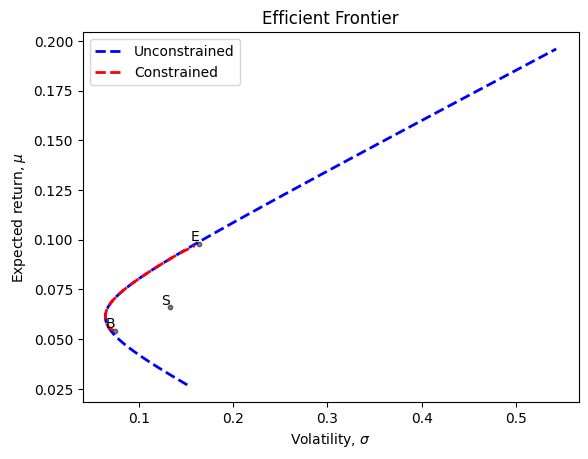

In [122]:
plt.plot(frontier_sigma_unconstr, frontier_mu_unconstr, 'b--', linewidth=2, label='Unconstrained')
plt.plot(frontier_sigma_constr, frontier_mu_constr, 'r--', linewidth=2, label='Constrained')
plt.legend()

plt.scatter(sigmas, mu_vec, color='black', alpha=0.5, s=40,marker='.')  # Adjust 's' for smaller/larger points

# Add labels for each point
for i, txt in enumerate(asset_labels):
    plt.text(sigmas[i], mu_vec[i], txt, ha='right', va='bottom')

# Add axis labels and title if needed
plt.xlabel(r'Volatility, $\sigma$')
plt.ylabel(r'Expected return, $\mu$')
plt.title('Efficient Frontier')

# Show the plot
plt.show()

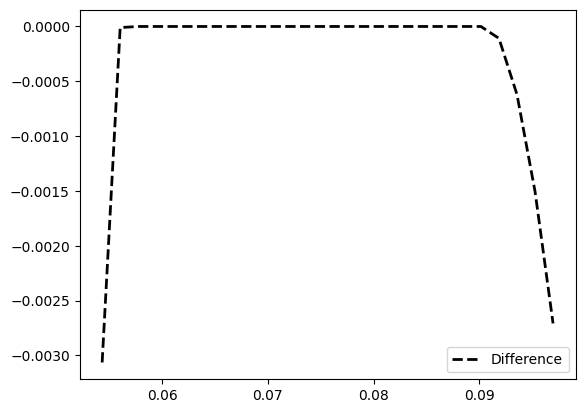

In [123]:
plt.plot(frontier_mu_unconstr, frontier_sigma_unconstr -frontier_sigma_constr, 'k--', linewidth=2, label='Difference')
plt.legend()

# Mean Variance frontier with real data

Now we repeat the above analysis with real data. We download data of a subset of publicly-traded US stocks.

First, let us import some packages that we need for our analysis

In [124]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import yfinance as yf



Here we can choose between
1. A small subset of a few stocks manually picked (set the variable small_set =1)
2. The entire set of 30 stocks that compose the DJIA index (set the variable small_set =0)

The next code block creates an array that contains the ticker symbols chosen



In [135]:
small_set = 0

if small_set == 1:
  symbols = ["AAPL", "MMM", "BA", "TSLA"] # Choose a small set of stocks
else: # Download all the symbols for firms in the DJIA index
  url = ("https://www.ssga.com/us/en/institutional/etfs/library-content/products/fund-data/etfs/us/holdings-daily-us-en-dia.xlsx")
  symbols = (pd.read_excel(url, skiprows=4, nrows=30)
    .get("Ticker")
    .tolist()
    )

len(symbols)

30

In the next block of code we download price information for the chosen stocks
you can select the start and end date

In [136]:
index_prices = (yf.download(tickers=symbols,
                            start="2000-01-01",
                            end="2024-01-07",
                            progress=True)
  .melt(ignore_index=False,
        var_name=["variable", "symbol"])
  .reset_index()
  .pivot(index=["Date", "symbol"],
         columns="variable",
         values="value")
  .reset_index()
  .rename(columns = {"Date": "date",
                     "Open": "open",
                     "High": "high",
                     "Low": "low",
                     "Close": "close",
                     "Adj Close": "adjusted",
                     "Volume": "volume"
                    })
)

[*********************100%%**********************]  30 of 30 completed


Let us take a peek at how the data we downloaded looks like by looking at the first few lines

In [137]:
index_prices.head()

variable,date,symbol,adjusted,close,high,low,open,volume
0,2000-01-03,AAPL,0.847207,0.999442,1.004464,0.907924,0.936384,535796800.0
1,2000-01-03,AMGN,45.597836,62.937500,70.000000,62.875000,70.000000,22914900.0
2,2000-01-03,AXP,32.956543,45.880306,47.995617,45.515598,47.995617,6471267.0
3,2000-01-03,BA,25.940275,40.187500,41.687500,39.812500,41.437500,2638200.0
4,2000-01-03,CAT,12.968643,24.312500,24.500000,23.843750,23.843750,5055000.0


As you see from the table above, the data are arranged by date/firms. We would like to rearrange the data so that each column contains the time series of adjusted prices for each firm. This is like doing a pivot table in Excel. We will use the command ".pivot" in the line of code below. Take a look at how the data looks like after we rearrange them

In [138]:
adjusted_prices = index_prices.pivot(index='date', columns='symbol', values='adjusted')

adjusted_prices.head()

symbol,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,DOW,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,0.847207,45.597836,32.956543,25.940275,12.968643,NaN,36.940601,17.326839,23.040161,NaN,...,26.873898,36.132271,4.654916,28.428757,17.992365,5.421882,NaN,17.758354,17.510696,43.555946
2000-01-04,0.775779,42.111202,31.712147,25.899950,12.801950,NaN,34.868183,17.326839,24.389793,NaN,...,25.930092,34.911709,4.401011,27.881716,17.753822,5.352532,NaN,17.184315,16.859308,41.926136
2000-01-05,0.787131,43.560192,30.906685,27.513651,13.101999,NaN,34.761356,17.637630,25.402021,NaN,...,26.948416,35.279812,4.654916,27.351261,17.617512,5.339924,NaN,17.758354,17.050903,41.070530
2000-01-06,0.719014,44.284683,31.536358,27.796045,13.768771,NaN,34.184494,18.388723,24.389793,NaN,...,27.171934,34.097996,4.630734,28.611095,17.958282,5.535365,NaN,17.668154,16.552782,41.518703
2000-01-07,0.753073,49.265572,31.995502,28.602892,14.218838,NaN,36.192829,18.712463,24.004190,NaN,...,29.779848,34.543602,4.630734,30.898640,18.673887,6.184728,NaN,17.537697,16.974276,44.656036


We now plot the data we downloaded

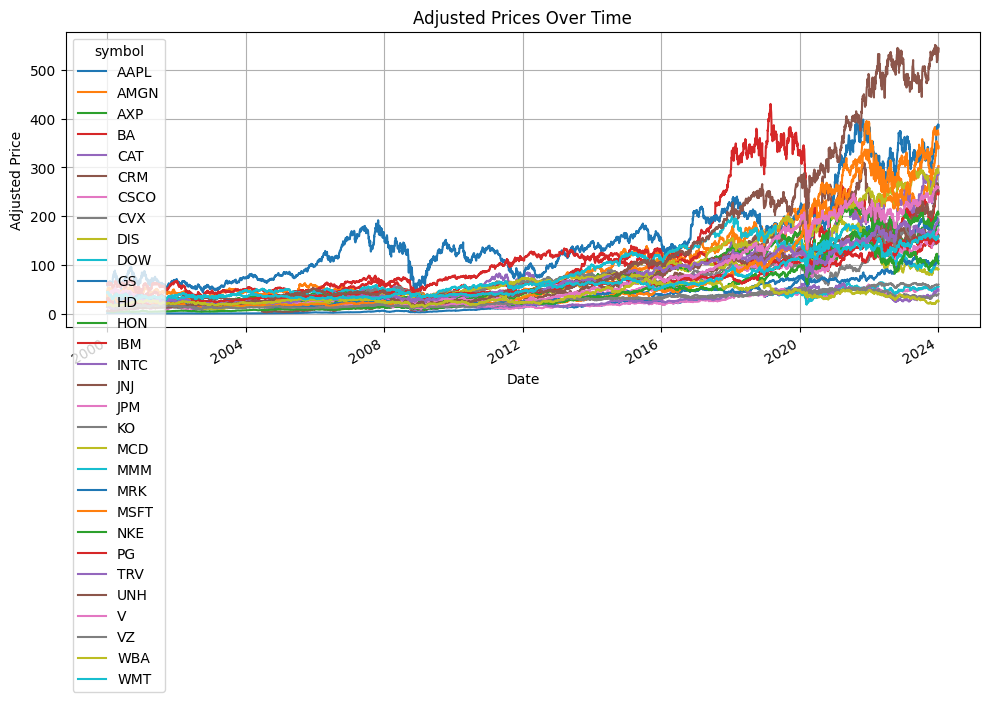

In [139]:
# Plotting adjusted prices
plt.figure(figsize=(10, 6))

adjusted_prices.plot(ax=plt.gca(), legend=True)  # Plot directly from DataFrame and remove legend


plt.title('Adjusted Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Adjusted Price')
plt.grid(True)
plt.tight_layout()


# Display the plot
plt.show()

From the prices we now compute returns. We compute daily net returns defined as $r_t = p_t/p_{t-1} -1$, where $p_t$ is the adjusted price on day $t$.
The function pct_change() is helpful because it computes this percentage change.

Before computing the returns, we use groupby("symbol") such that the assign() command is performed for each symbol individually.

In [140]:
# all_returns = (index_prices
#   .assign(ret = lambda x: x.groupby("symbol")["adjusted"].pct_change())
#   .get(["symbol", "date", "ret"])
#   .dropna(subset="ret")
# )

# (all_returns
#   .groupby("symbol")["ret"]
#   .describe()
#   .round(3)
# )


# Step 1: Compute daily returns for each stock in the dataset
returns_with_index_prices = index_prices.assign(
    ret=lambda x: x.groupby("symbol")["adjusted"].pct_change()
)

# Step 2: Select required columns and drop rows with missing returns
filtered_returns = returns_with_index_prices[["symbol", "date", "ret"]].dropna(subset=["ret"])

# Step 3: Calculate summary statistics for daily returns by stock symbol
summary_statistics = (
    filtered_returns.groupby("symbol")["ret"]
    .describe()
    .round(3)
)

returns_with_index_prices.tail(10)


variable,date,symbol,adjusted,close,high,low,open,volume,ret
181220,2024-01-05,MRK,117.220001,117.220001,117.449997,116.639999,117.099998,6860100.0,0.001795
181221,2024-01-05,MSFT,367.750000,367.750000,372.059998,366.500000,368.970001,20987000.0,-0.000516
181222,2024-01-05,NKE,102.080002,102.080002,103.680000,101.900002,102.459999,8039900.0,-0.002151
181223,2024-01-05,PG,147.419998,147.419998,148.869995,146.550003,148.720001,5294200.0,-0.008274
181224,2024-01-05,TRV,193.070007,193.070007,194.110001,191.690002,191.690002,1580700.0,0.002753
181225,2024-01-05,UNH,537.380005,537.380005,547.000000,533.729980,547.000000,2815400.0,-0.014741
181226,2024-01-05,V,259.690002,259.690002,261.459991,258.750000,260.779999,3748400.0,0.000308
181227,2024-01-05,VZ,40.200001,40.200001,40.369999,39.299999,39.470001,30212900.0,0.021082
181228,2024-01-05,WBA,25.010000,25.010000,25.010000,23.520000,24.160000,25898900.0,0.030915
181229,2024-01-05,WMT,156.710007,156.710007,158.100006,155.600006,157.919998,7235600.0,-0.006656


In [92]:
# prices = (index_prices
#   .groupby("symbol", group_keys=False)
#   .apply(lambda x: x.assign(counts = x["adjusted"].dropna().count()))
#   .reset_index(drop=True)
#   .query("counts == counts.max()")
# )

# prices = index_prices
# prices.head()

Here we create a table in which each column contains monthly returns. We use this data to compute the mean and covariance matrix.

In [141]:
# returns_matrix = (prices
#   .pivot(columns="symbol",
#          values="adjusted",
#          index="date")
#   .resample("m")
#   .last()
#   .pct_change()
#   .dropna()
# )

# Step 1: Pivot the prices DataFrame to create a matrix of adjusted prices with dates as rows and symbols as columns
prices_matrix = index_prices.pivot(
    columns="symbol",
    values="adjusted",
    index="date"
)

# Step 2: Resample the pivoted matrix to monthly frequency and select the last value of each month
monthly_prices = prices_matrix.resample("M").last()

# Step 3: Calculate the percentage change of the monthly prices matrix
returns_matrix = monthly_prices.pct_change()

# Step 4: Drop rows with missing values (NaNs) resulting from percentage change calculation
returns_matrix = returns_matrix.dropna()


returns_matrix.head()

symbol,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,DOW,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
date,,,,,,,,,,,,,,,,,,,,,
2019-04-30,0.056436,-0.056112,0.076349,-0.009779,0.035243,0.044074,0.042864,-0.025329,0.233631,0.098780,...,-0.053625,0.107343,0.042988,0.030579,0.048046,-0.057389,0.052756,-0.022844,-0.153311,0.054445
2019-05-31,-0.124213,-0.062373,-0.021496,-0.090332,-0.140654,-0.084306,-0.070062,-0.042394,-0.035993,-0.163727,...,0.006353,-0.049481,-0.119268,-0.033527,0.012661,0.037457,-0.017344,-0.049659,-0.071178,-0.008373
2019-06-30,0.130519,0.105459,0.076105,0.065572,0.137551,0.002113,0.051893,0.093017,0.057558,0.054534,...,0.065649,0.083118,0.088281,0.065494,0.032819,0.013609,0.075745,0.051150,0.108026,0.089215
2019-07-31,0.076394,0.012481,0.010685,-0.062718,-0.026464,0.018256,0.018630,-0.010688,0.030476,-0.017643,...,-0.010256,0.017244,0.024777,0.083488,-0.019396,0.020491,0.025641,-0.022374,-0.003293,-0.000996
2019-08-31,-0.016461,0.126048,-0.032162,0.073808,-0.096226,0.010162,-0.155054,-0.033952,-0.040207,-0.105211,...,0.041933,0.015037,-0.015247,0.018553,0.002319,-0.060279,0.017309,0.052289,-0.051960,0.040247


We now compute the mean monthly return and the covariance matrix

In [142]:
# Compute the mean, covariance matrix, and a vector of volatilities

mu_vec = np.array(returns_matrix.mean()).T
cov_matrix = np.array(returns_matrix.cov())
sigma_vec = np.sqrt(np.diag(cov_matrix))

print(mu_vec)
print(cov_matrix)
print(sigma_vec)


[ 0.02772897  0.01308627  0.01454696  0.00273951  0.01951888  0.01341086
  0.00422432  0.01162271  0.0019564   0.0102752   0.01829286  0.01463346
  0.00845631  0.00905955  0.00453773  0.00589643  0.01517899  0.00814123
  0.01069931 -0.00527372  0.0110965   0.02262172  0.00796076  0.00937464
  0.00975854  0.01659599  0.01169189 -0.00118598 -0.00777628  0.0109008 ]
[[0.00772317 0.00218903 0.00366759 0.00438357 0.00334585 0.00632169
  0.00293092 0.00268335 0.00511012 0.00394426 0.00424854 0.00344655
  0.00330118 0.00214943 0.00377016 0.00192877 0.00294591 0.00181345
  0.0027124  0.00346602 0.00093937 0.00415409 0.00422386 0.00197138
  0.00111357 0.00184688 0.00357992 0.00112812 0.00210886 0.00208227]
 [0.00218903 0.00516889 0.00148853 0.00238838 0.0031437  0.00128117
  0.00177946 0.00343422 0.00207936 0.00250061 0.00252035 0.00196475
  0.001975   0.00216286 0.00315836 0.00210408 0.00173472 0.00122756
  0.00162587 0.00286357 0.00217162 0.00103963 0.00145036 0.00138585
  0.0009565  0.002097

Let us check the mean and volatility of a generic portfolio w

In [143]:
w = np.ones(len(mu_vec)) * (1.0 / len(mu_vec))

print(portfolio_return(w, mu_vec))

print(portfolio_volatility(w, cov_matrix))


0.009992359299088599
0.05267570408784076


We can now call our function that construct the mean variance frontier. We construct both an unconstrained and constrained frontier

In [144]:
frontier_sigma_unconstr, frontier_mu_unconstr = construct_mv_frontier(mu_vec, cov_matrix, constr_sw = 0)
frontier_sigma_constr, frontier_mu_constr = construct_mv_frontier(mu_vec, cov_matrix, constr_sw = 1)

Here we plot the frontier and the different stocks we used to construct it

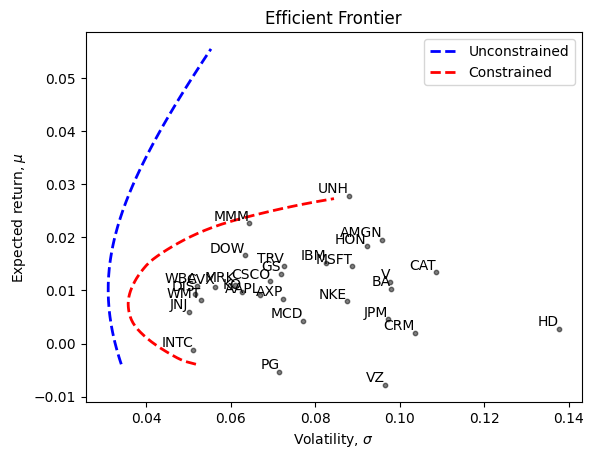

In [145]:
plt.plot(frontier_sigma_unconstr, frontier_mu_unconstr, 'b--', linewidth=2, label='Unconstrained')
plt.plot(frontier_sigma_constr, frontier_mu_constr, 'r--', linewidth=2, label='Constrained')


plt.scatter(sigma_vec, mu_vec, color='black', alpha=0.5, s=40,marker='.')  # Adjust 's' for smaller/larger points

# Add labels for each point
for i, txt in enumerate(symbols):
    plt.text(sigma_vec[i], mu_vec[i], txt, ha='right', va='bottom')

plt.legend()

# Add axis labels and title if needed
plt.xlabel(r'Volatility, $\sigma$')
plt.ylabel(r'Expected return, $\mu$')
plt.title('Efficient Frontier')

# Show the plot
plt.show()